# Momentum Trading Strategy

In [12]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt


In [13]:
tickers_list = ['AMZN']

df_tic = pd.read_hdf("datasets/df_SnP_500_ohlcv.h5", "df", mode = 'r')
df_tic = df_tic[df_tic['tic'].isin(tickers_list)]

In [14]:
df_tic.head(5)

,date,tic,open,high,low,close,adj_close,volume
0,2021-01-04,AMZN,163.500000,163.600006,157.201004,159.331497,159.331497,88228000.0
1,2021-01-05,AMZN,158.300507,161.169006,158.253006,160.925507,160.925507,53110000.0
2,2021-01-06,AMZN,157.324005,159.875504,156.557999,156.919006,156.919006,87896000.0
3,2021-01-07,AMZN,157.850006,160.427002,157.750000,158.108002,158.108002,70290000.0
4,2021-01-08,AMZN,159.000000,159.531998,157.110001,159.134995,159.134995,70754000.0


In [15]:
df_tic.drop(columns=['tic','adj_close', 'volume'], inplace = True)
df_tic.head()

,date,open,high,low,close
0,2021-01-04,163.500000,163.600006,157.201004,159.331497
1,2021-01-05,158.300507,161.169006,158.253006,160.925507
2,2021-01-06,157.324005,159.875504,156.557999,156.919006
3,2021-01-07,157.850006,160.427002,157.750000,158.108002
4,2021-01-08,159.000000,159.531998,157.110001,159.134995


In [16]:
df_tic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    680 non-null    datetime64[ns]
 1   open    680 non-null    float64       
 2   high    680 non-null    float64       
 3   low     680 non-null    float64       
 4   close   680 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 31.9 KB


### 2. Add data/transform data
* calculate signal based on some price or statistical action
* we are going to try a moving average crossover to generate signals
* for this strategy we will always by "in" a trade, either long or short
* we are modeling; this means real life variation should be expected

#### Add moving averages to the data frame

In [17]:
df_tic['9-day'] = df_tic['close'].rolling(21).mean()
df_tic['21-day'] = df_tic['close'].rolling(50).mean()
df_tic[19:25]

,date,open,high,low,close,9-day,21-day
19,2021-02-01,162.117996,167.513000,161.751495,167.143997,NaN,NaN
20,2021-02-02,169.000000,171.386993,168.056503,169.000000,160.770952,NaN
21,2021-02-03,171.250504,171.699997,165.431000,165.626495,161.070714,NaN
22,2021-02-04,166.500000,167.350006,163.887497,166.550003,161.338547,NaN
23,2021-02-05,165.949997,168.850006,165.135498,167.607498,161.847523,NaN
24,2021-02-08,167.925003,168.250000,165.199997,166.147003,162.230332,NaN


#### Add "signal" column  

In [18]:
df_tic['signal'] = np.where(df_tic['9-day'] > df_tic['21-day'], 1, 0)
df_tic['signal'] = np.where(df_tic['9-day'] < df_tic['21-day'], -1, df_tic['signal'])
df_tic.dropna(inplace=True)
df_tic.head()

,date,open,high,low,close,9-day,21-day,signal
49,2021-03-16,155.248505,156.445496,153.792999,154.593002,155.984144,159.48718,-1
50,2021-03-17,153.660995,158.652496,153.511002,156.786499,155.666954,159.43628,-1
51,2021-03-18,155.050003,155.831497,151.250000,151.399506,154.998739,159.24576,-1
52,2021-03-19,151.461502,153.864502,150.831497,153.748001,154.395716,159.18234,-1
53,2021-03-22,153.392502,156.328995,153.002502,155.543503,154.064692,159.13105,-1


#### Calculate Instantaneous returns/system returns

In [19]:
df_tic['return'] = np.log(df_tic['close']).diff()
df_tic['system_return'] = df_tic['signal'] * df_tic['return']
df_tic['entry'] = df_tic.signal.diff()
df_tic.head()

,date,open,high,low,close,9-day,21-day,signal,return,system_return,entry
49,2021-03-16,155.248505,156.445496,153.792999,154.593002,155.984144,159.48718,-1,NaN,NaN,NaN
50,2021-03-17,153.660995,158.652496,153.511002,156.786499,155.666954,159.43628,-1,0.014089,-0.014089,0.0
51,2021-03-18,155.050003,155.831497,151.250000,151.399506,154.998739,159.24576,-1,-0.034963,0.034963,0.0
52,2021-03-19,151.461502,153.864502,150.831497,153.748001,154.395716,159.18234,-1,0.015393,-0.015393,0.0
53,2021-03-22,153.392502,156.328995,153.002502,155.543503,154.064692,159.13105,-1,0.011611,-0.011611,0.0


#### Plot trades on time series

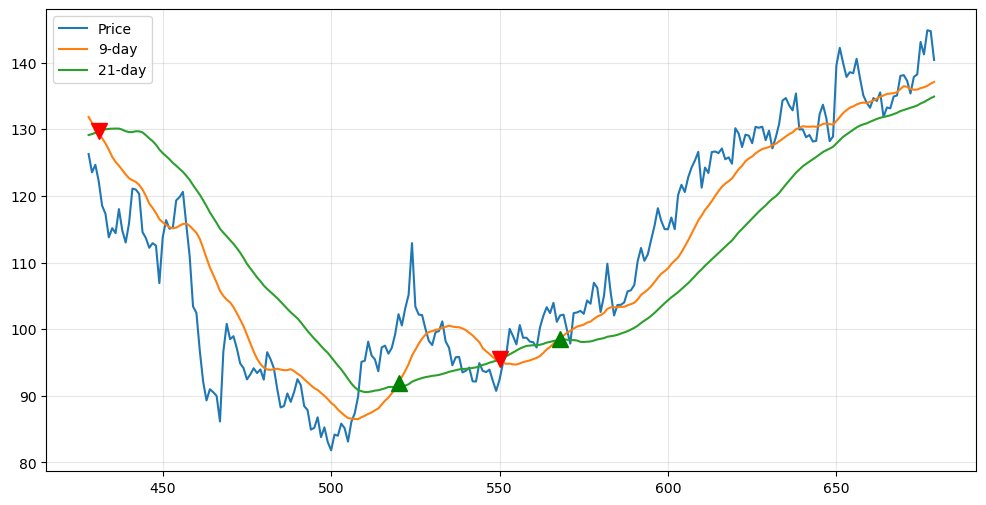

In [20]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(df_tic.iloc[-252:]['close'], label = 'Price')
plt.plot(df_tic.iloc[-252:]['9-day'], label = '9-day')
plt.plot(df_tic.iloc[-252:]['21-day'], label = '21-day')
plt.plot(df_tic[-252:].loc[df_tic.entry == 2].index, df_tic[-252:]['9-day'][df_tic.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(df_tic[-252:].loc[df_tic.entry == -2].index, df_tic[-252:]['21-day'][df_tic.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

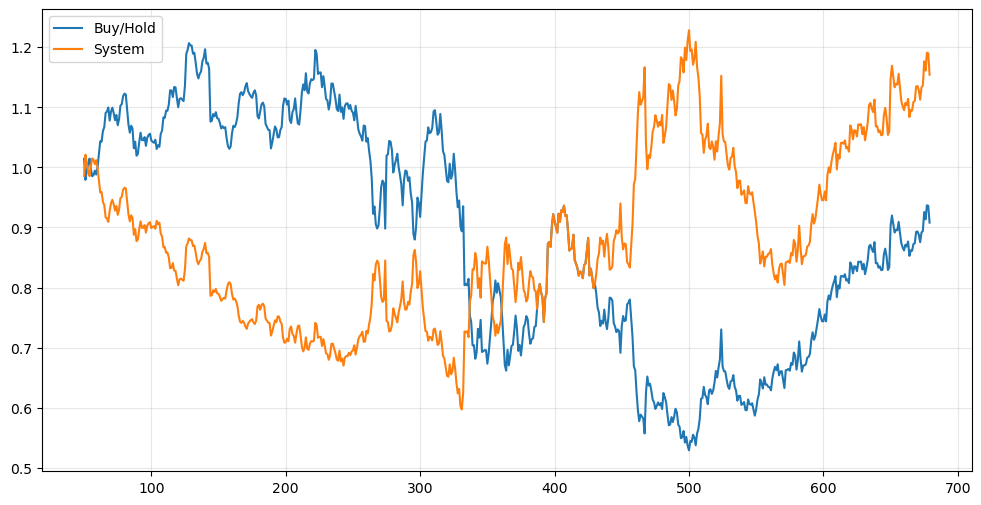

In [21]:
plt.plot(np.exp(df_tic['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(df_tic['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [23]:
print(f"Cumulative Return Buy-&-Hold: {round(100*(np.exp(df_tic['return']).cumprod().iloc[-1]-1),3)}")
print(f"Cumulative Return Strategy: {round(100*(np.exp(df_tic['system_return']).cumprod().iloc[-1]-1),3)}")

Cumulative Return Buy-&-Hold: -9.187
Cumulative Return Strategy: 15.416
